# Inicialização

## Inicialização das dependências

In [1]:
!pip install yfinance pandas matplotlib statsmodels
import yfinance as yf
import pandas as pd
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from matplotlib import pyplot
import tensorflow as tf
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras import metrics
from keras import backend
from datetime import datetime
from pandas_datareader.data import DataReader
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from keras.layers import LSTM

## Obtenção de dados e tratamento inicial

In [2]:
# Datas
data_inicio_acoes = "2022-05-01"# 1 ano
data_fim_acoes = "2023-05-01"

data_inicio_crypto = "2022-11-01" # 6 Meses
data_fim_crypto = "2023-05-01"

data_inicio_tsm = "2022-01-01" # 1 anos e 5 meses
data_fim_tsm = "2023-05-01"

data_inicio_btc = "2021-05-01" # 2 anos
data_fim_btc = "2023-05-01"

#start_date = '2023-06-01'
#end_date = '2023-06-25'
# Ações da bolsa
# IBM
def dataibm():
  df_ibm = yf.download("IBM", start=data_inicio_acoes, end=data_fim_acoes).reset_index()
  df_ibm.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_ibm.dropna(inplace = True)
  return df_ibm
# AMAZON
def dataamzn():
  df_amzn = yf.download("AMZN",start=data_inicio_acoes, end=data_fim_acoes).reset_index()
  df_amzn.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_amzn.dropna(inplace = True)
  return df_amzn
# TSM
def datatsm():
  df_tsm = yf.download("TSM", start=data_inicio_tsm, end=data_fim_tsm).reset_index()
  df_tsm.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_tsm.dropna(inplace = True)
  return df_tsm
# Criptomoedas
# BITCOIN
def databtc():
  df_btc = yf.download('BTC-USD', start=data_inicio_btc, end=data_fim_btc).reset_index()
  df_btc.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_btc.dropna(inplace=True)
  return df_btc
# ETHERUM
def dataeth():
  df_eth = yf.download('ETH-USD', start=data_inicio_crypto, end=data_fim_crypto).reset_index()
  df_eth.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_eth.dropna(inplace=True)
  return df_eth
# MONERO
def dataxmr():
  df_xmr = yf.download('XMR-USD', start=data_inicio_crypto, end=data_fim_crypto).reset_index()
  df_xmr.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
  df_xmr.dropna(inplace=True)
  return df_xmr

## Função amostragem

In [3]:
# Função amostragem
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):
        break
    # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
      X.append(seq_x)
      y.append(seq_y)
    return array(X), array(y)

# Análise dos Dados

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


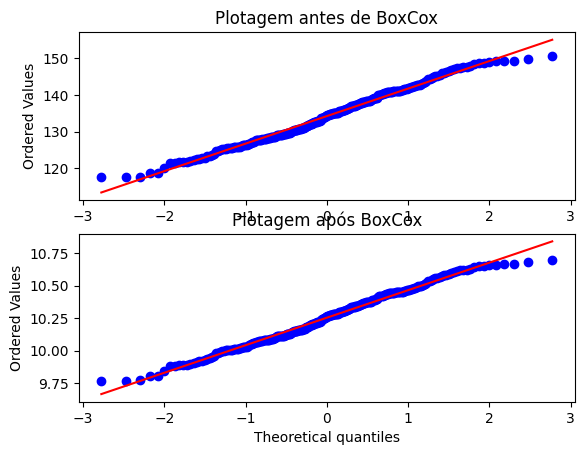

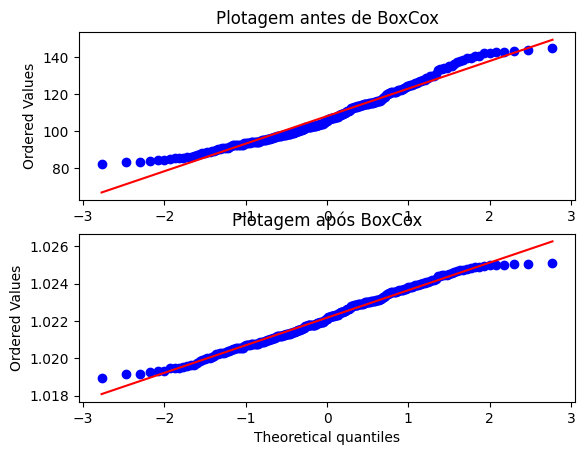

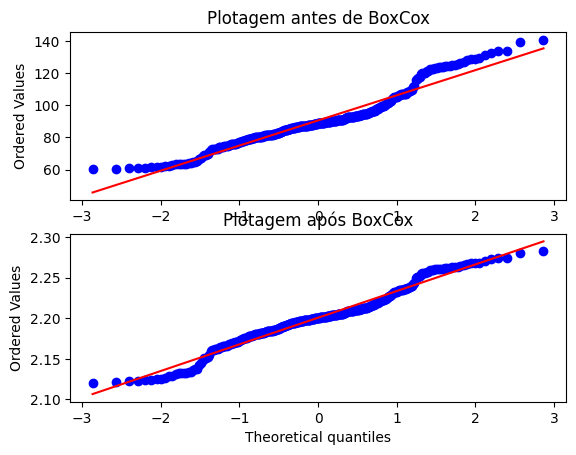

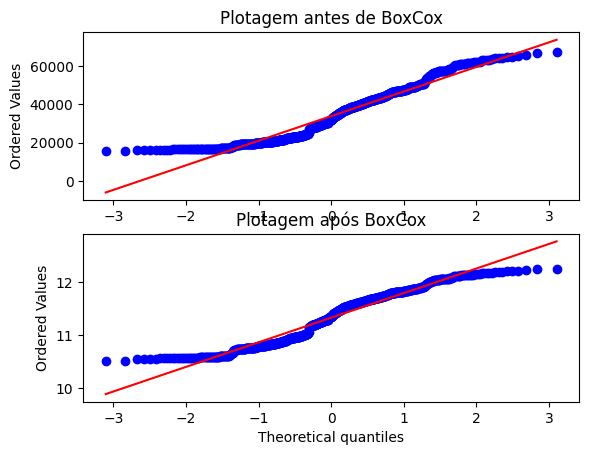

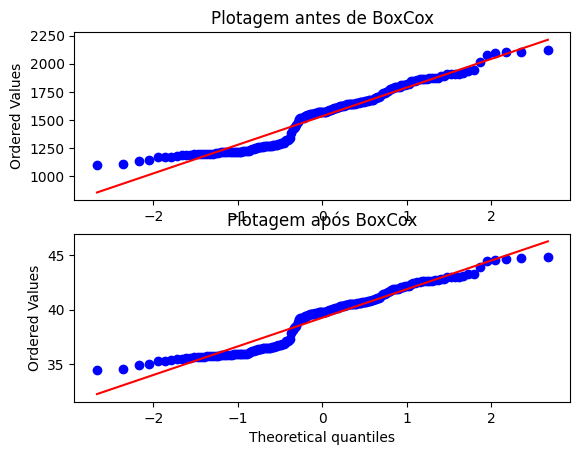

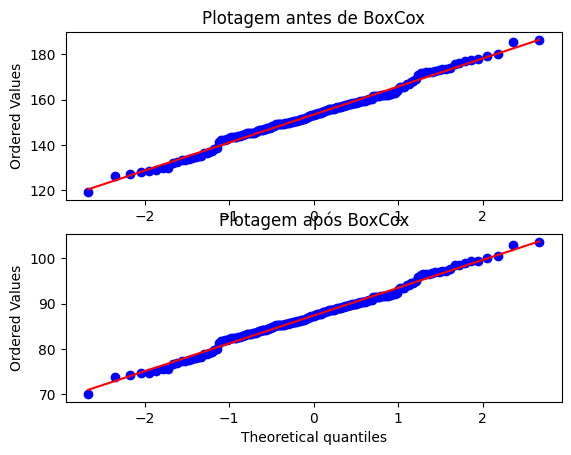

In [4]:
# Funções
def demoBoxCox(data):
  fig = plt.figure()

  ax1 = fig.add_subplot(211)
  prob = stats.probplot(data["Close"], dist=stats.norm, plot=ax1)
  data_t = data
  ax1.set_xlabel('')

  ax1.set_title('Plotagem antes de BoxCox')
  ax2 = fig.add_subplot(212)

  data_t["Close"], _ = stats.boxcox(data["Close"])

  prob = stats.probplot(data_t["Close"], dist=stats.norm, plot=ax2)

  ax2.set_title('Plotagem após BoxCox')
  plt.show()
  '''
  Separamos a base em treino e teste utilizando a seguinte função
  como o problema é de regressão apenas separamos em teste/treino
  '''
# Demonstração de normalidade antes/pós BoxCox
ibm = dataibm()
amzn = dataamzn()
tsm = datatsm()
btc = databtc()
eth = dataeth()
xmr = dataxmr()
demoBoxCox(ibm)
demoBoxCox(amzn)
demoBoxCox(tsm)
demoBoxCox(btc)
demoBoxCox(eth)
demoBoxCox(xmr)

# Modelos Deep Learning

In [5]:
'''
Aqui estaram os modelos de deep learning respectivos modelados para o projeto.

# funções recebe os seguintes argumentos:
# data = dados da série temporal / tipo: df
# legenda = legenda para plotagem da previsão / tipo: string
# op = argumento para aplicar transformação boxcox no conjunto
#   0 = não aplica ; 1 = aplica / tipo: num


Os parametros do modelo divergem de cada modelo, mas de toda forma
as funções seguem a seguinte sequência no geral:
:> 1 Transformação de df em objeto ts, obtenção do tamanho de treino e teste
:> 2 Aplicação de transformação BoxCox (Caso op = 1)
:> 3 Encaixe do modelo
:> 4 Previsão do modelo
:> 5 Transformação inversa da BoxCox para escala original dos valores previstos (Caso op = 1)
:> 6 Análise de residuais e cálculo de acurácia
:> 7 Imprimir valores previstos, atuais e exibir conforme dado do conjunto de teste
:> 8 Plotagem do modelo de previsão

# OBS: Sendo que o passo 2 e o passo 5 só são aplicados caso seja optado a transformação
# todo modelo segue essa sequencia no todo porém cada um tem seu próprio modo
# de elaboração do modelo

# Seguiram nesse formato de elaboração de modelo e posteriormente chamada
# dos modelos sem e com transformações sendo no total 12 chamadas para modelo
'''

'\nAqui estaram os modelos de deep learning respectivos modelados para o projeto.\n\n# funções recebe os seguintes argumentos:\n# data = dados da série temporal / tipo: df\n# legenda = legenda para plotagem da previsão / tipo: string\n# op = argumento para aplicar transformação boxcox no conjunto\n#   0 = não aplica ; 1 = aplica / tipo: num\n\n\nOs parametros do modelo divergem de cada modelo, mas de toda forma\nas funções seguem a seguinte sequência no geral:\n:> 1 Transformação de df em objeto ts, obtenção do tamanho de treino e teste\n:> 2 Aplicação de transformação BoxCox (Caso op = 1)\n:> 3 Encaixe do modelo\n:> 4 Previsão do modelo\n:> 5 Transformação inversa da BoxCox para escala original dos valores previstos (Caso op = 1)\n:> 6 Análise de residuais e cálculo de acurácia\n:> 7 Imprimir valores previstos, atuais e exibir conforme dado do conjunto de teste\n:> 8 Plotagem do modelo de previsão\n\n# OBS: Sendo que o passo 2 e o passo 5 só são aplicados caso seja optado a transforma

## CNN

In [6]:

# Modelo CNN
def prevCNN(data, op):
  if(op == 1):
    # Se op for 1 aplica transformação BoxCox
    data["Close"], lbd = stats.boxcox(data["Close"])

  # Transforma em série temporal
  ts_data =  pd.Series(data=data["Close"].values, index = data["Date"])
  # Separação base/treino


  # Numero de passos para prever equivale ao treinamento e
  # tanto de previsão equivale à saida
  train_size = int(len(ts_data) * 0.8)
  test_size = len(ts_data) - train_size
  train, test = ts_data[:train_size], ts_data[train_size:]
  print(len(train))
  print(len(test))
  #ts_data.shape

  # Amostragem
  X, y = split_sequence(ts_data, train_size, test_size)
  print(y)


  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  # Define o modelo
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_size, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  # Gerar tamanho de teste
  model.add(Dense(test_size))
  model.compile(optimizer='adam', loss='mse', metrics=[metrics.mean_squared_error, metrics.mean_absolute_error, metrics.mean_absolute_percentage_error, metrics.cosine_proximity])
  # Encaixe do modelo
  model.fit(X, y, epochs=100, verbose=0)
  # Gera previsão
  X.shape
  train = np.array(train)
  train  = train.reshape((1, train_size, n_features))
    # Inversa BoxCox
  if(op == 1):
    # Converte valores BoxCox para escala original utilizando lambda da transformação
    y[0] = inv_boxcox(y[0], lbd)
    train = inv_boxcox(train, lbd)
    test = inv_boxcox(test, lbd)
    X[0] = inv_boxcox(X[0], lbd)
  valores_previstos = model.predict(train, verbose=0)
  print("previstos")
  print(valores_previstos)



  for i in range(len(valores_previstos[0])):
      print(f"Data:{data['Date'][train_size+ i]} Previsto: {valores_previstos[0][i]} Atual: {y[0][i]}")
   #Calcula os residuais

  residuais = []
  for i in range(len(valores_previstos[0])):
      result = y[0][i] - valores_previstos[0][i]
      residuais.append(result)

  # Compute the ACF of the residuals
  acf = sm.tsa.acf(residuais, nlags=20)

  # Plotting the ACF
  plt.figure(figsize=(10, 4))
  sm.graphics.tsa.plot_acf(residuais, lags=20)
  plt.xlabel('Lag')
  plt.ylabel('Autocorrelação')
  plt.title('Autocorrelation Function (ACF) de residuais do modelo')

  # Display the plot
  plt.show()

  mae = mean_absolute_error(y[0], valores_previstos[0])
  mse = mean_squared_error(y[0], valores_previstos[0])
  rmse = sqrt(mse)
  mape = mean_absolute_percentage_error(y[0], valores_previstos[0])
  print("Accurácia da previsão")
  print(f"RMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}\n")


[*********************100%***********************]  1 of 1 completed
200
50
[[135.         135.02000427 131.71000671 130.97000122 130.78999329
  130.57000732 130.49000549 129.30000305 128.19000244 128.92999268
  129.63999939 130.19000244 128.25       128.05000305 126.16000366
  125.44999695 125.58000183 124.65000153 123.27999878 124.69999695
  123.69000244 125.94000244 126.56999969 124.05000305 123.37000275
  125.29000092 129.30999756 129.33999634 129.71000671 129.22000122
  131.08999634 132.05999756 131.6000061  132.13999939 130.5
  131.02999878 130.41999817 128.53999329 127.90000153 128.13999939
  127.81999969 127.77999878 126.31999969 126.36000061 125.73000336
  125.40000153 125.88999939 125.84999847 126.97000122 126.41000366]]
previstos
[[140.44225  131.62457  119.72075  131.12656  108.072395  45.64227
  131.07256  120.5665   130.20178  132.21898  131.90263  127.29946
  133.38681  125.53416  136.6914   122.18379  126.99822  131.81364
  125.755104 122.843155 125.060936 131.73706  12

<Figure size 1000x400 with 0 Axes>

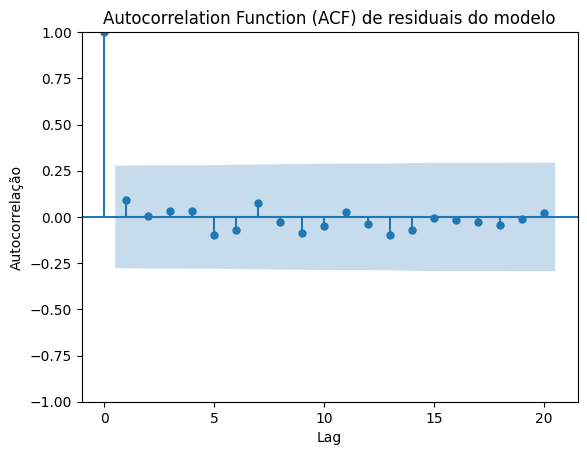

Accurácia da previsão
RMSE: 16.545348997893132
MAE: 8.263027420043946
MAPE: 0.06395648313686504



In [7]:
# OBS: Chamada novamente pois ambiente sobreescreve dados
ibm = dataibm()
prevCNN(ibm, 0)

[*********************100%***********************]  1 of 1 completed
200
50
[[10.27862477 10.27918696 10.18532726 10.16410891 10.1589343  10.15260342
  10.15029916 10.11590187 10.08360864 10.10515967 10.12575298 10.14164911
  10.08535934 10.07952119 10.02401934 10.00301277 10.00686562  9.97923978
   9.93826889  9.98072871  9.95056495 10.01751951 10.03611047  9.96133697
   9.94097067  9.99826711 10.11619172 10.11706162 10.12777905 10.11358114
  10.16755548 10.1953324  10.18217869 10.19761669 10.15058708 10.16583248
  10.14828192 10.09381282 10.07513811 10.08214911 10.07279891 10.07162891
  10.02874116 10.02992099 10.01130747 10.00153033 10.01604104 10.014858
  10.04787941 10.03139545]]
previstos
[[142.85869  136.06334  138.25876  145.1684   141.18343  127.27166
  135.00255  105.25824  129.54375  109.85796  135.93755  140.7822
  140.5517   133.9182   147.89311  133.2989   141.60397  133.65897
  132.41313  132.78305  141.87428  134.70378  102.81238  134.07716
   68.09493  141.51347  134.7

<Figure size 1000x400 with 0 Axes>

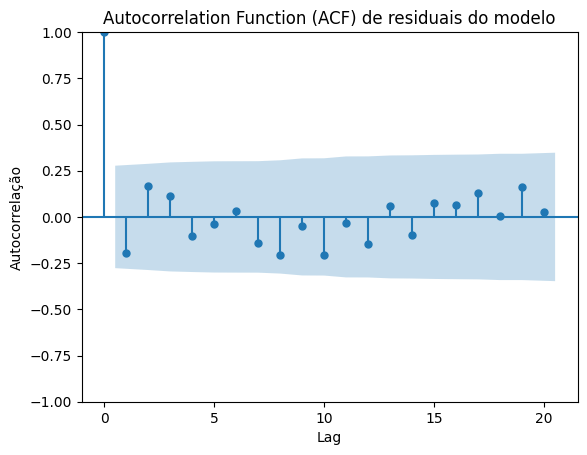

Accurácia da previsão
RMSE: 15.957064439559492
MAE: 12.140558776855457
MAPE: 0.09540473336888866



In [8]:
ibm = dataibm()
prevCNN(ibm, 1)

[*********************100%***********************]  1 of 1 completed
200
50
[[ 98.15000153  97.19999695  94.58000183  95.79000092  95.81999969
   93.5         93.76000214  94.23000336  92.16999817  92.12999725
   94.90000153  93.75        93.55000305  93.91999817  92.25
   90.73000336  92.43000031  94.87999725  96.19999695 100.04000092
   98.94999695  97.70999908 100.61000061  98.69999695  98.70999908
   98.12999725  98.04000092  97.23999786 100.25       102.
  103.29000092 102.41000366 103.94999695 101.09999847 102.05999756
  102.16999817  99.91999817  97.83000183 102.40000153 102.51000214
  102.73999786 102.30000305 104.30000305 103.80999756 106.95999908
  106.20999908 102.56999969 104.98000336 109.81999969 105.44999695]]
previstos
[[106.18495   95.46946   94.23122   92.89264   92.92024   93.90645
   93.707504  96.75119   91.58797   86.9817    94.716385  92.7428
   90.18277   94.178276  92.51129   91.81018   95.8132    95.18066
   95.89477  105.37832   97.46808   94.961334 101.59648 

<Figure size 1000x400 with 0 Axes>

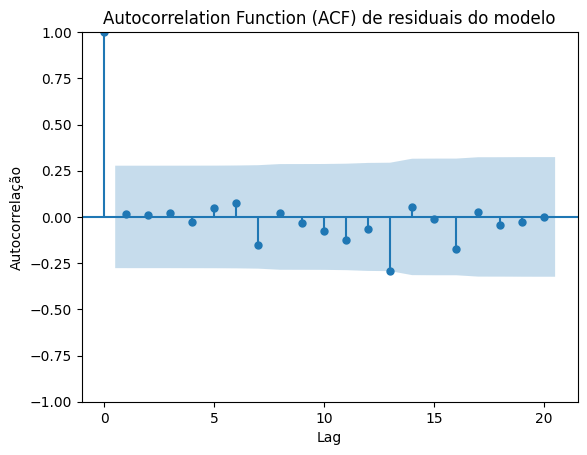

Accurácia da previsão
RMSE: 3.7907976977087894
MAE: 2.0334403991699217
MAPE: 0.0204251940627731



In [9]:
amzn = dataamzn()
prevCNN(amzn, 0)

[*********************100%***********************]  1 of 1 completed
200
50
[[1.02129144 1.02117591 1.02084548 1.02100029 1.02100408 1.02070396
  1.02073832 1.02079996 1.02052521 1.02051976 1.0208868  1.02073701
  1.02071059 1.02075938 1.02053611 1.02032587 1.02056055 1.02088422
  1.02105188 1.02151486 1.02138703 1.02123821 1.02158061 1.02135732
  1.02135851 1.02128903 1.02127817 1.02118082 1.02153917 1.02173794
  1.02188022 1.02178354 1.02195167 1.02163656 1.02174464 1.02175689
  1.02150092 1.02125277 1.02178244 1.02179461 1.02181999 1.02177134
  1.0219892  1.02193659 1.02226653 1.02218972 1.02180124 1.02206141
  1.02254996 1.02211079]]
previstos
[[115.45805  118.780396 116.20042  117.593376 123.270256 121.444374
  113.95784  123.59512  121.55727  114.98958  119.16128  117.363846
  116.44158  116.18389  121.36966  115.40755  115.59267  120.68413
  115.21395  121.34403  121.69722  120.23138  120.13471  120.50468
  122.33165  117.411674 119.27237  122.43119  122.43577  122.151695
  117.

<Figure size 1000x400 with 0 Axes>

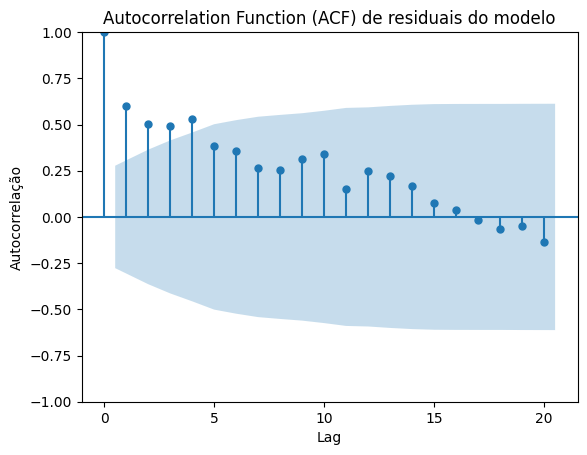

Accurácia da previsão
RMSE: 20.661571836704535
MAE: 20.04651443481445
MAPE: 0.20496958891724545



In [10]:
amzn = dataamzn()
prevCNN(amzn, 1)

[*********************100%***********************]  1 of 1 completed
265
67
[[94.55999756 92.41000366 93.44999695 93.30000305 93.12999725 92.73000336
  94.73999786 96.65000153 94.66000366 91.83000183 94.55000305 94.27999878
  96.69000244 95.37000275 96.11000061 97.95999908 92.76000214 90.81999969
  90.09999847 87.63999939 86.83000183 90.08000183 88.11000061 87.30000305
  87.06999969 88.41999817 89.02999878 89.79000092 89.58000183 88.84999847
  90.83000183 88.87999725 87.25       87.73999786 89.29000092 86.69999695
  89.30000305 89.47000122 90.04000092 92.5        92.62000275 94.58999634
  92.79000092 90.66000366 90.80999756 92.76000214 92.47000122 93.01999664
  92.83999634 92.16999817 90.19999695 90.23999786 89.01999664 89.23999786
  86.87000275 87.05000305 87.19999695 87.98999786 88.13999939 87.23000336
  89.29000092 85.37000275 84.63999939 82.29000092 82.25       83.66999817
  84.30000305]]


previstos
[[94.62988  92.64518  93.593025 92.68999  93.554596 92.694885 94.92017
  96.73863  94.568985 92.09731  94.396164 94.05802  95.51622  95.243256
  94.412895 97.352585 92.60121  90.38614  90.866295 87.04854  86.25699
  90.708984 88.158165 87.80877  87.00679  88.08476  88.57686  89.767555
  88.617355 87.54897  91.03361  89.3504   87.379974 87.857796 90.81226
  87.02523  88.74938  89.06591  89.377815 92.3112   92.428276 94.378395
  92.072426 92.57375  90.70221  92.90085  92.20307  92.9979   93.07955
  91.898026 89.766304 89.008934 88.86527  89.36869  87.04936  87.67238
  88.306305 88.21907  88.65514  87.252335 89.5189   86.060356 85.12768
  82.47662  82.05185  83.22678  84.35412 ]]
Data:2023-01-24 00:00:00 Previsto: 94.6298828125 Atual: 94.55999755859375
Data:2023-01-25 00:00:00 Previsto: 92.64517974853516 Atual: 92.41000366210938
Data:2023-01-26 00:00:00 Previsto: 93.59302520751953 Atual: 93.44999694824219
Data:2023-01-27 00:00:00 Previsto: 92.68998718261719 Atual: 93.30000305175

<Figure size 1000x400 with 0 Axes>

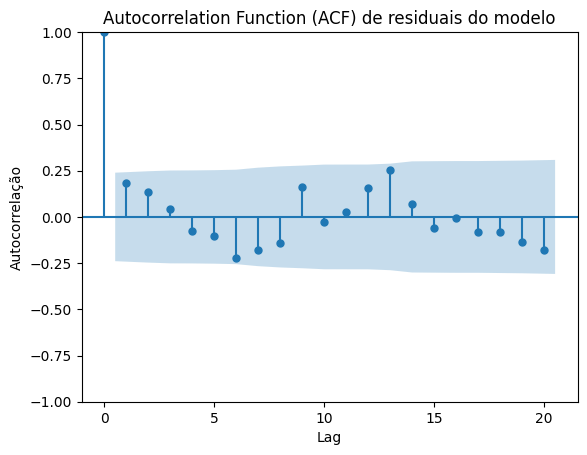

Accurácia da previsão
RMSE: 0.591534749866021
MAE: 0.42602197447819495
MAPE: 0.004720205967763437



In [11]:
tsm = datatsm()
prevCNN(tsm, 0)

[*********************100%***********************]  1 of 1 completed
265
67
[[2.21274158 2.20838595 2.21050995 2.21020561 2.20985986 2.20904296
  2.2131001  2.21684787 2.21294089 2.20718715 2.21272165 2.21218204
  2.21692527 2.21434761 2.21579862 2.2193603  2.20910439 2.20507469
  2.20354908 2.19820819 2.19640458 2.20350647 2.19924433 2.19745391
  2.19694137 2.19992361 2.2012508  2.20288708 2.20243685 2.20086047
  2.20509577 2.2009256  2.19734264 2.19842928 2.20181273 2.19611296
  2.2018343  2.20220044 2.20342119 2.20857104 2.20881746 2.2128014
  2.20916579 2.2047371  2.20505361 2.20910439 2.20850937 2.20963569
  2.20926807 2.20789113 2.20376196 2.20384702 2.20122914 2.20170483
  2.19649419 2.19689672 2.19723129 2.1989805  2.19931021 2.19729812
  2.20181273 2.19309481 2.19141077 2.18585184 2.18575535 2.1891421
  2.19061964]]


previstos
[[102.78208   93.56865   97.031456  82.21645   73.8205    92.17516
   92.09715   93.05835   92.92186   90.65294   92.14041   98.42638
   98.6393    95.075325  71.90002   17.677155  73.595726  33.967503
   76.10541   87.24794   98.95032   50.155174  97.10082   93.10334
   85.76026   91.60959   87.707695  87.18412   91.47326  101.542984
   99.37375   84.08262   56.488316  93.859665  98.68093   81.9128
   88.74345   92.28007   97.94163   85.29485   99.910126  91.820496
   92.12325   91.38887   92.862114  97.12653   57.46105   92.994675
   91.79131   92.03986   99.190445  92.20995   86.288284  96.145615
   84.52557   95.26602   91.33961  117.83658   91.22182   94.8322
   97.98745   97.04592   92.204575  84.126274  92.2281    77.50589
   49.281284]]
Data:2023-01-24 00:00:00 Previsto: 102.7820816040039 Atual: 94.55999755859385
Data:2023-01-25 00:00:00 Previsto: 93.56864929199219 Atual: 92.41000366210925
Data:2023-01-26 00:00:00 Previsto: 97.03145599365234 Atual: 93.44999694824217
D

<Figure size 1000x400 with 0 Axes>

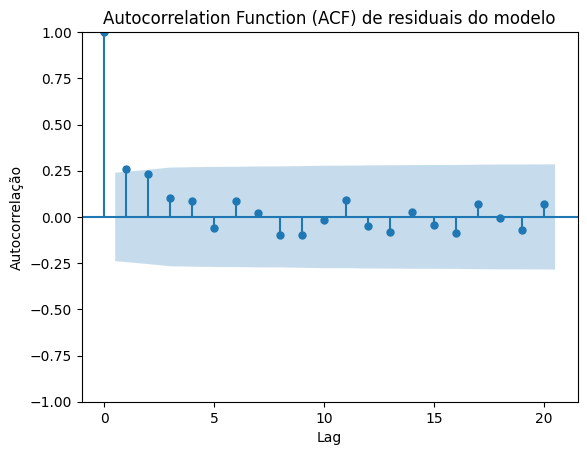

Accurácia da previsão
RMSE: 16.81603063871253
MAE: 9.557216928966016
MAPE: 0.10548518880448263



In [12]:
tsm = datatsm()
prevCNN(tsm, 1)

[*********************100%***********************]  1 of 1 completed
584
146
[[17089.50390625 16848.12695312 17233.47460938 17133.15234375
  17128.72460938 17104.19335938 17206.4375     17781.31835938
  17815.65039062 17364.86523438 16647.484375   16795.09179688
  16757.9765625  16439.6796875  16906.3046875  16817.53515625
  16830.34179688 16796.953125   16847.75585938 16841.98632812
  16919.8046875  16717.17382812 16552.57226562 16642.34179688
  16602.5859375  16547.49609375 16625.08007812 16688.47070312
  16679.85742188 16863.23828125 16836.73632812 16951.96875
  16955.078125   17091.14453125 17196.5546875  17446.29296875
  17934.89648438 18869.58789062 19909.57421875 20976.29882812
  20880.79882812 21169.6328125  21161.51953125 20688.78125
  21086.79296875 22676.55273438 22777.625      22720.41601562
  22934.43164062 22636.46875    23117.859375   23032.77734375
  23078.72851562 23031.08984375 23774.56640625 22840.13867188
  23139.28320312 23723.76953125 23471.87109375 23449.32226562

<Figure size 1000x400 with 0 Axes>

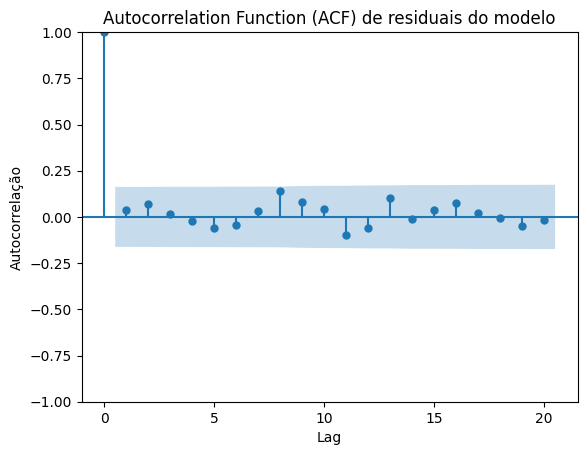

Accurácia da previsão
RMSE: 184.63416597858347
MAE: 137.92356057363014
MAPE: 0.006211563793241204



In [13]:
btc = databtc()
prevCNN(btc, 0)

[*********************100%***********************]  1 of 1 completed
584
146
[[10.60850408 10.59169195 10.618421   10.61151929 10.61121377 10.60951966
  10.61656487 10.65542714 10.65770876 10.62740058 10.57753584 10.58796629
  10.5853521  10.56269654 10.59576563 10.58954432 10.59044385 10.58809724
  10.59166592 10.59126117 10.59670895 10.58247162 10.5707809  10.57717081
  10.57434513 10.57041855 10.57594473 10.58044116 10.57983119 10.59275139
  10.59089274 10.59895345 10.59917021 10.60861755 10.61588568 10.63293211
  10.66560013 10.72572637 10.78927786 10.85115985 10.84574733 10.86204341
  10.86158865 10.8347906  10.85739203 10.94367065 10.94895313 10.94596598
  10.9571031  10.94156928 10.96656747 10.96218668 10.96455463 10.96209963
  10.99985697 10.95220884 10.96766807 10.99731444 10.98462665 10.98348437
  10.97751585 10.95820253 10.94803934 10.97407012 10.95736035 10.89789905
  10.8887328  10.90071571 10.89622037 10.89730389 10.91956021 11.02623121
  10.99227866 11.03877605 11.042434

<Figure size 1000x400 with 0 Axes>

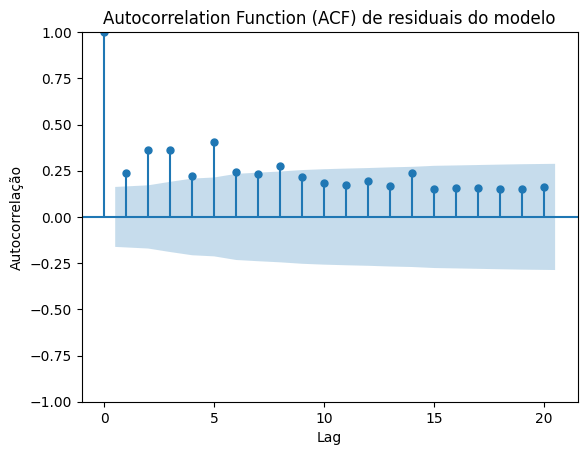

Accurácia da previsão
RMSE: 12938.784083653294
MAE: 12182.55909540882
MAPE: 0.5786007843306092



In [14]:
btc = databtc()
prevCNN(btc, 1)

[*********************100%***********************]  1 of 1 completed
144
37
[[160.06416321 161.56651306 152.21069336 153.93919373 158.92948914
  155.26771545 157.70718384 158.12037659 160.22416687 156.54754639
  158.70545959 158.03793335 156.4262085  156.78434753 158.2855835
  160.32949829 159.21882629 162.16339111 162.41989136 162.09362793
  162.11958313 162.51071167 163.61671448 159.5622406  162.78260803
  153.15402222 153.66047668 151.26608276 157.5        157.36422729
  157.60606384 159.79107666 156.88517761 153.84681702 153.32824707
  154.71839905 156.45655823]]
previstos
[[163.10277 159.48042 150.44568 153.48933 158.25145 156.02766 158.58578
  159.83919 160.6352  156.27266 158.8535  159.6149  156.65768 156.60811
  159.77501 160.249   160.09033 161.48055 162.35449 161.80417 159.96478
  161.17017 164.10966 160.50775 162.72322 155.54996 152.89967 152.20465
  157.8946  157.30344 158.30927 159.81017 157.81477 153.79523 153.16124
  155.19208 156.29912]]
Data:2023-03-25 00:00:00 Previst

<Figure size 1000x400 with 0 Axes>

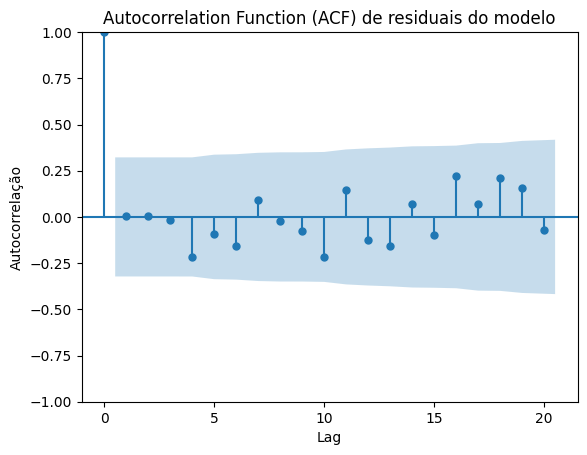

Accurácia da previsão
RMSE: 1.098177581822924
MAE: 0.8031958502692145
MAPE: 0.005085701962638231



In [15]:
xmr= dataxmr()
prevCNN(xmr, 0)

[*********************100%***********************]  1 of 1 completed
144
37
[[90.71494885 91.45710014 86.81939105 87.67912666 90.15378624 88.33900662
  89.54866217 89.75329322 90.7940355  88.97396085 90.04292491 89.71246967
  88.91379328 89.09136432 89.83509009 90.84609276 90.29693304 91.75168781
  91.87823659 91.71726414 91.73007161 91.9230377  92.46834388 90.46678714
  92.05714174 87.28875867 87.54058711 86.34898088 89.4460277  89.37875862
  89.49857181 90.5799422  89.14134731 87.63321361 87.37540292 88.06625525
  88.92884335]]
previstos
[[157.28537 161.90588 149.71498 157.07605 159.52654 152.46257 156.93031
  157.47365 160.54247 158.88635 157.61218 157.14584 156.9817  148.1142
  156.28157 152.95657 161.83678 157.92607 160.74352 161.15857 161.62305
  161.55237 161.89706 153.3645  160.99629 156.13834 153.19719 152.0575
  149.20537 156.45932 167.72237 160.14928 160.71011 142.8721  169.00255
  157.6512  154.05525]]
Data:2023-03-25 00:00:00 Previsto: 157.28536987304688 Atual: 160.0641632

<Figure size 1000x400 with 0 Axes>

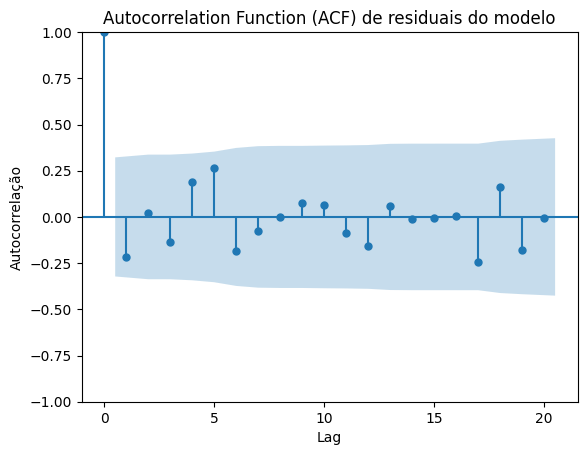

Accurácia da previsão
RMSE: 4.724146578706239
MAE: 3.166702270507824
MAPE: 0.02018386563044407



In [16]:
xmr= dataxmr()
prevCNN(xmr, 1)

[*********************100%***********************]  1 of 1 completed
144
37
[[1743.76477051 1775.67675781 1715.46081543 1772.78564453 1793.00183105
  1792.73718262 1822.02209473 1813.8605957  1795.70812988 1810.29711914
  1871.00512695 1909.11401367 1872.92260742 1865.6361084  1849.49816895
  1859.38781738 1911.20751953 1892.18969727 1920.68212891 2012.63464355
  2101.63549805 2092.46679688 2120.00585938 2076.24291992 2104.53735352
  1936.40344238 1943.09765625 1849.99987793 1874.2286377  1862.06201172
  1842.75744629 1866.75366211 1866.56420898 1908.78637695 1892.51281738
  1908.91699219 1876.92431641]]
previstos
[[1734.4464 1777.5829 1710.7427 1769.0781 1777.375  1813.2427 1810.3341
  1840.3755 1799.7979 1797.1843 1863.7269 1902.0842 1900.7    1867.2358
  1866.9427 1857.5188 1906.594  1875.0906 1887.8936 2012.4729 2106.0068
  2100.298  2112.532  2081.3262 2104.9932 1975.8486 1940.9509 1900.8156
  1873.7258 1868.2457 1825.1855 1868.5956 1860.7344 1939.1598 1893.4102
  1894.539  1875.8

<Figure size 1000x400 with 0 Axes>

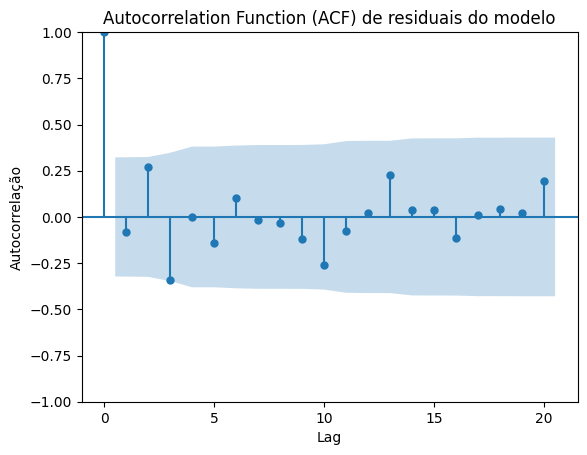

Accurácia da previsão
RMSE: 16.614444036369004
MAE: 11.48868045291385
MAPE: 0.006133092274527609



In [17]:
eth = dataeth()
prevCNN(eth, 0)

[*********************100%***********************]  1 of 1 completed
144
37
[[41.47681394 41.77921714 41.20570039 41.75196076 41.94197487 41.93949606
  42.21241879 42.13663373 41.96731011 42.10347774 42.6628718  43.00826475
  42.68035478 42.61385928 42.46600823 42.55670923 43.02711381 42.85540992
  43.11225868 43.92532646 44.69052328 44.61263907 44.84593662 44.47430115
  44.71512916 43.25296456 43.31266163 42.47061682 42.69225637 42.5811834
  42.40401358 42.62406841 42.62233797 43.00531368 42.85833619 43.00649019
  42.71680519]]
previstos
[[1538.5878 1582.4397 1569.749  1613.5686 1603.0756 1591.3948 1608.8191
  1579.9071 1587.1576 1575.0377 1586.9773 1635.5887 1589.6318 1615.8757
  1590.2141 1580.3708 1634.7223 1626.5017 1640.944  1651.0194 1740.5381
  1677.1279 1675.6057 1690.9794 1686.4712 1614.7958 1631.1312 1598.5974
  1606.8492 1608.7133 1607.1519 1609.3434 1625.1317 1619.3743 1587.8042
  1627.5127 1610.2511]]
Data:2023-03-25 00:00:00 Previsto: 1538.5877685546875 Atual: 1743.76477

<Figure size 1000x400 with 0 Axes>

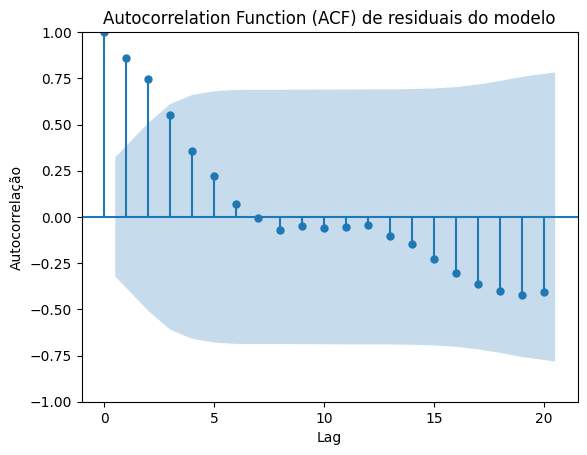

Accurácia da previsão
RMSE: 281.4593078105443
MAE: 273.09533361486507
MAPE: 0.14310881189691144



In [18]:
eth = dataeth()
prevCNN(eth, 1)

## MLP

In [19]:
# Modelo MLP
def prevMLP(data, op):
  if(op == 1):
    # Se op for 1 aplica transformação BoxCox
    data["Close"], lbd = stats.boxcox(data["Close"])

  # Transforma em série temporal
  ts_data =  pd.Series(data=data["Close"].values, index = data["Date"])
  # Separação base/treino


  # Numero de passos para prever equivale ao treinamento e
  # tanto de previsão equivale à saida
  train_size = int(len(ts_data) * 0.8)
  test_size = len(ts_data) - train_size
  train, test = ts_data[:train_size], ts_data[train_size:]
  print(len(train))
  print(len(test))
  #ts_data.shape

  # Amostragem
  X, y = split_sequence(ts_data, train_size, test_size)
  print(y)

  # Problema regressor então features equivalem 1
  n_features = 1
  X = X.reshape((X.shape[0], X.shape[1], n_features))

  # Define o modelo
  model = Sequential()
  model.add(Dense(100, activation='relu', input_dim=train_size))
  model.add(Dense(test_size))
  model.compile(optimizer='adam', loss='mse', metrics=[metrics.mean_squared_error, metrics.mean_absolute_error, metrics.mean_absolute_percentage_error, metrics.cosine_proximity])
  # Encaixe do modelo
  model.fit(X, y, epochs=50, verbose=0)
  # Gera previsão
  X.shape
  train = np.array(train)
  train  = train.reshape((1, train_size, n_features))
    # Inversa BoxCox
  if(op == 1):
    # Converte valores BoxCox para escala original utilizando lambda da transformação
    y[0] = inv_boxcox(y[0], lbd)
    train = inv_boxcox(train, lbd)
    test = inv_boxcox(test, lbd)
    X[0] = inv_boxcox(X[0], lbd)
  valores_previstos = model.predict(train, verbose=0)
  print("previstos")
  print(valores_previstos)



  for i in range(len(valores_previstos[0])):
      print(f"Data:{data['Date'][train_size+ i]} Previsto: {valores_previstos[0][i]} Atual: {y[0][i]}")
  # Calcula os residuais

  residuais = []
  for i in range(len(valores_previstos[0])):
      result = y[0][i] - valores_previstos[0][i]
      residuais.append(result)

  # Compute the ACF of the residuals
  acf = sm.tsa.acf(residuais, nlags=20)

  # Plotting the ACF
  plt.figure(figsize=(10, 4))
  sm.graphics.tsa.plot_acf(residuais, lags=20)
  plt.xlabel('Lag')
  plt.ylabel('Autocorrelação')
  plt.title('Autocorrelation Function (ACF) de residuais do modelo')

  # Display the plot
  plt.show()

  mae = mean_absolute_error(y[0], valores_previstos[0])
  mse = mean_squared_error(y[0], valores_previstos[0])
  rmse = sqrt(mse)
  mape = mean_absolute_percentage_error(y[0], valores_previstos[0])
  print("Accurácia da previsão")
  print(f"RMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}\n")

[*********************100%***********************]  1 of 1 completed
200
50
[[135.         135.02000427 131.71000671 130.97000122 130.78999329
  130.57000732 130.49000549 129.30000305 128.19000244 128.92999268
  129.63999939 130.19000244 128.25       128.05000305 126.16000366
  125.44999695 125.58000183 124.65000153 123.27999878 124.69999695
  123.69000244 125.94000244 126.56999969 124.05000305 123.37000275
  125.29000092 129.30999756 129.33999634 129.71000671 129.22000122
  131.08999634 132.05999756 131.6000061  132.13999939 130.5
  131.02999878 130.41999817 128.53999329 127.90000153 128.13999939
  127.81999969 127.77999878 126.31999969 126.36000061 125.73000336
  125.40000153 125.88999939 125.84999847 126.97000122 126.41000366]]
previstos
[[129.44469  125.47665  133.43372  132.95439  129.13242  132.21101
  129.62871  129.71005  130.21352  123.846725 131.92763  131.85327
  122.06137  136.92809  130.23198  127.20227  121.92152  127.53178
  116.40959  116.04339  131.7305   129.82631  13

<Figure size 1000x400 with 0 Axes>

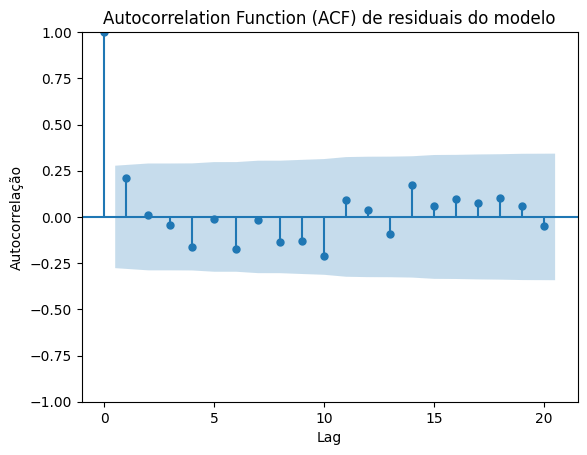

Accurácia da previsão
RMSE: 5.782846627177229
MAE: 4.8249664306640625
MAPE: 0.03776398353680789



In [20]:
ibm = dataibm()
prevMLP(ibm, 0)

[*********************100%***********************]  1 of 1 completed
200
50
[[10.27862477 10.27918696 10.18532726 10.16410891 10.1589343  10.15260342
  10.15029916 10.11590187 10.08360864 10.10515967 10.12575298 10.14164911
  10.08535934 10.07952119 10.02401934 10.00301277 10.00686562  9.97923978
   9.93826889  9.98072871  9.95056495 10.01751951 10.03611047  9.96133697
   9.94097067  9.99826711 10.11619172 10.11706162 10.12777905 10.11358114
  10.16755548 10.1953324  10.18217869 10.19761669 10.15058708 10.16583248
  10.14828192 10.09381282 10.07513811 10.08214911 10.07279891 10.07162891
  10.02874116 10.02992099 10.01130747 10.00153033 10.01604104 10.014858
  10.04787941 10.03139545]]
previstos
[[128.91139  139.1092   139.68883  123.69249  146.28644  132.5899
  133.4509   130.97118  137.7466   130.53235  123.90115  126.310776
  122.651695 122.95534  133.35637  134.39279  110.88229  137.22948
  131.9863   135.53467  122.80119  126.89036  145.20433  125.94652
  152.63962  131.11388  120.

<Figure size 1000x400 with 0 Axes>

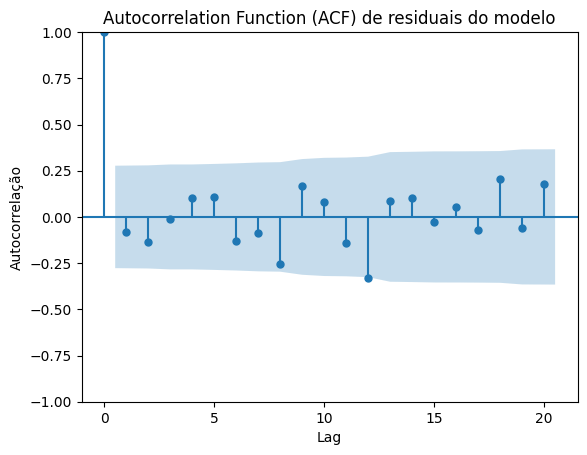

Accurácia da previsão
RMSE: 8.744465667237218
MAE: 6.500669860839833
MAPE: 0.05091823503974765



In [21]:
ibm = dataibm()
prevMLP(ibm, 1)

[*********************100%***********************]  1 of 1 completed
200
50
[[ 98.15000153  97.19999695  94.58000183  95.79000092  95.81999969
   93.5         93.76000214  94.23000336  92.16999817  92.12999725
   94.90000153  93.75        93.55000305  93.91999817  92.25
   90.73000336  92.43000031  94.87999725  96.19999695 100.04000092
   98.94999695  97.70999908 100.61000061  98.69999695  98.70999908
   98.12999725  98.04000092  97.23999786 100.25       102.
  103.29000092 102.41000366 103.94999695 101.09999847 102.05999756
  102.16999817  99.91999817  97.83000183 102.40000153 102.51000214
  102.73999786 102.30000305 104.30000305 103.80999756 106.95999908
  106.20999908 102.56999969 104.98000336 109.81999969 105.44999695]]
previstos
[[104.48619   94.00544   93.04669   93.765045  93.35995   94.97329
   95.13493   88.9056    93.789566  89.43773   90.24136   93.556244
   84.23752   88.79073   91.26981   90.76173   94.2411    92.71147
  101.179276  98.75235  103.61953   99.87003   93.0711

<Figure size 1000x400 with 0 Axes>

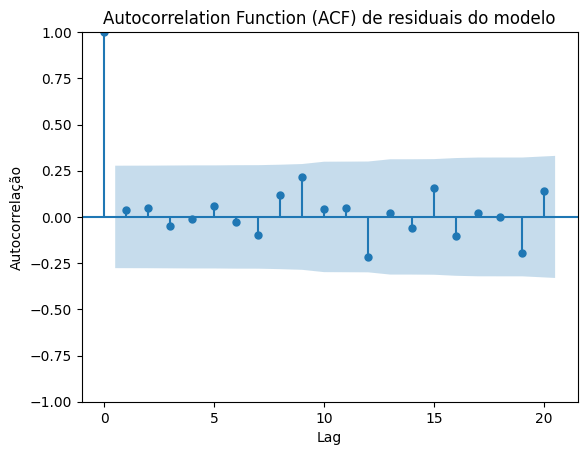

Accurácia da previsão
RMSE: 4.739299311609098
MAE: 3.532510528564453
MAPE: 0.03538961983923208



In [22]:
amzn = dataamzn()
prevMLP(amzn, 0)

[*********************100%***********************]  1 of 1 completed
200
50
[[1.02129144 1.02117591 1.02084548 1.02100029 1.02100408 1.02070396
  1.02073832 1.02079996 1.02052521 1.02051976 1.0208868  1.02073701
  1.02071059 1.02075938 1.02053611 1.02032587 1.02056055 1.02088422
  1.02105188 1.02151486 1.02138703 1.02123821 1.02158061 1.02135732
  1.02135851 1.02128903 1.02127817 1.02118082 1.02153917 1.02173794
  1.02188022 1.02178354 1.02195167 1.02163656 1.02174464 1.02175689
  1.02150092 1.02125277 1.02178244 1.02179461 1.02181999 1.02177134
  1.0219892  1.02193659 1.02226653 1.02218972 1.02180124 1.02206141
  1.02254996 1.02211079]]
previstos
[[110.61241  101.99178   86.45905   95.949005  82.6312    87.63226
  115.504005 106.16029  120.7481    75.79807   88.493675 116.266396
  105.77604   71.35131  106.416985 127.96338  103.83763   94.95281
  108.45076  112.243835 116.46105   82.86657  102.50034   83.58402
  108.85753  108.5595   116.471085 100.454185 140.94226  101.86326
  106.61

<Figure size 1000x400 with 0 Axes>

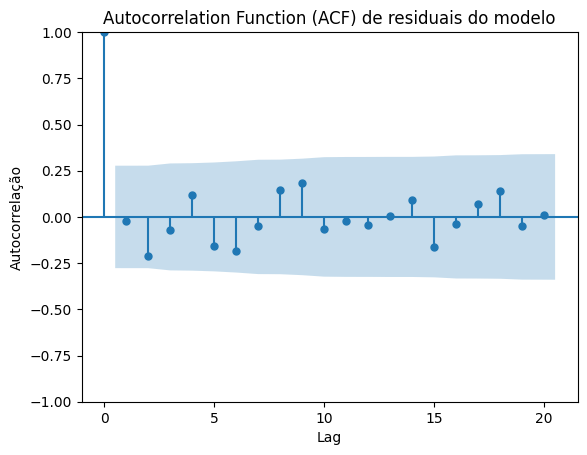

Accurácia da previsão
RMSE: 14.608202295104384
MAE: 11.36151473999032
MAPE: 0.11660981286412288



In [23]:
amzn = dataamzn()
prevMLP(amzn, 1)

[*********************100%***********************]  1 of 1 completed
265
67
[[94.55999756 92.41000366 93.44999695 93.30000305 93.12999725 92.73000336
  94.73999786 96.65000153 94.66000366 91.83000183 94.55000305 94.27999878
  96.69000244 95.37000275 96.11000061 97.95999908 92.76000214 90.81999969
  90.09999847 87.63999939 86.83000183 90.08000183 88.11000061 87.30000305
  87.06999969 88.41999817 89.02999878 89.79000092 89.58000183 88.84999847
  90.83000183 88.87999725 87.25       87.73999786 89.29000092 86.69999695
  89.30000305 89.47000122 90.04000092 92.5        92.62000275 94.58999634
  92.79000092 90.66000366 90.80999756 92.76000214 92.47000122 93.01999664
  92.83999634 92.16999817 90.19999695 90.23999786 89.01999664 89.23999786
  86.87000275 87.05000305 87.19999695 87.98999786 88.13999939 87.23000336
  89.29000092 85.37000275 84.63999939 82.29000092 82.25       83.66999817
  84.30000305]]
previstos
[[ 91.39193   81.96665   91.20237   89.85341   89.74716   90.76295
  102.208984  99.

<Figure size 1000x400 with 0 Axes>

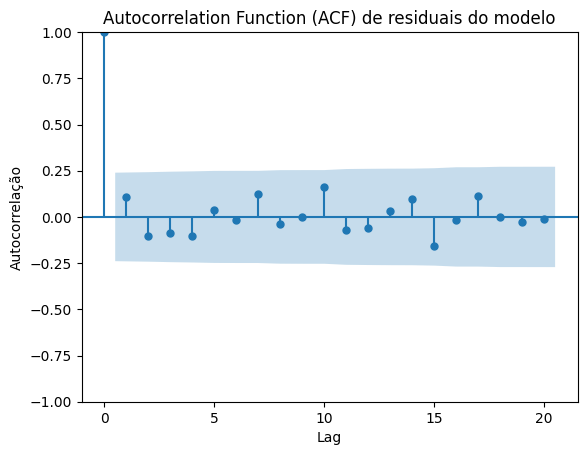

Accurácia da previsão
RMSE: 8.90051062376186
MAE: 6.25819248939628
MAPE: 0.06954729447438955



In [24]:
tsm = datatsm()
prevMLP(tsm, 0)

[*********************100%***********************]  1 of 1 completed
265
67
[[2.21274158 2.20838595 2.21050995 2.21020561 2.20985986 2.20904296
  2.2131001  2.21684787 2.21294089 2.20718715 2.21272165 2.21218204
  2.21692527 2.21434761 2.21579862 2.2193603  2.20910439 2.20507469
  2.20354908 2.19820819 2.19640458 2.20350647 2.19924433 2.19745391
  2.19694137 2.19992361 2.2012508  2.20288708 2.20243685 2.20086047
  2.20509577 2.2009256  2.19734264 2.19842928 2.20181273 2.19611296
  2.2018343  2.20220044 2.20342119 2.20857104 2.20881746 2.2128014
  2.20916579 2.2047371  2.20505361 2.20910439 2.20850937 2.20963569
  2.20926807 2.20789113 2.20376196 2.20384702 2.20122914 2.20170483
  2.19649419 2.19689672 2.19723129 2.1989805  2.19931021 2.19729812
  2.20181273 2.19309481 2.19141077 2.18585184 2.18575535 2.1891421
  2.19061964]]
previstos
[[101.27552   86.216     92.37057   88.19013   95.988335  87.371635
   70.40535   75.6222    93.84539   89.70484   88.37151  105.54709
   95.67203   86.8

<Figure size 1000x400 with 0 Axes>

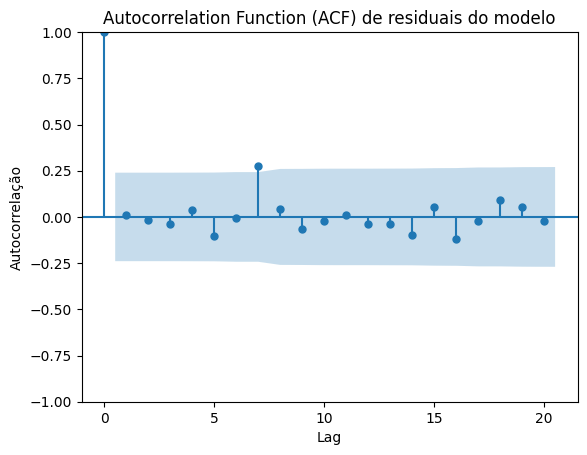

Accurácia da previsão
RMSE: 10.108391613927623
MAE: 8.190382089187834
MAPE: 0.09081727873497639



In [25]:
tsm = datatsm()
prevMLP(tsm, 1)

[*********************100%***********************]  1 of 1 completed
584
146
[[17089.50390625 16848.12695312 17233.47460938 17133.15234375
  17128.72460938 17104.19335938 17206.4375     17781.31835938
  17815.65039062 17364.86523438 16647.484375   16795.09179688
  16757.9765625  16439.6796875  16906.3046875  16817.53515625
  16830.34179688 16796.953125   16847.75585938 16841.98632812
  16919.8046875  16717.17382812 16552.57226562 16642.34179688
  16602.5859375  16547.49609375 16625.08007812 16688.47070312
  16679.85742188 16863.23828125 16836.73632812 16951.96875
  16955.078125   17091.14453125 17196.5546875  17446.29296875
  17934.89648438 18869.58789062 19909.57421875 20976.29882812
  20880.79882812 21169.6328125  21161.51953125 20688.78125
  21086.79296875 22676.55273438 22777.625      22720.41601562
  22934.43164062 22636.46875    23117.859375   23032.77734375
  23078.72851562 23031.08984375 23774.56640625 22840.13867188
  23139.28320312 23723.76953125 23471.87109375 23449.32226562

<Figure size 1000x400 with 0 Axes>

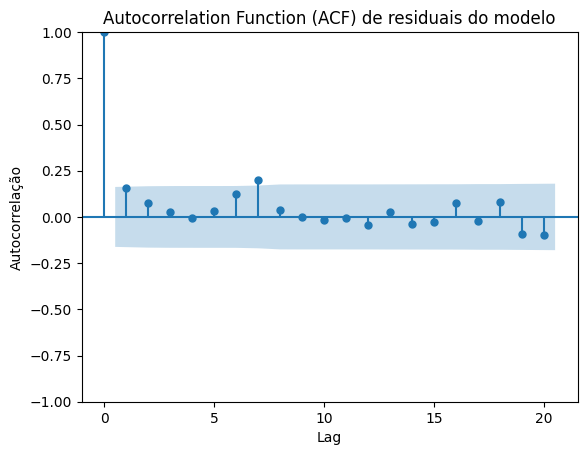

Accurácia da previsão
RMSE: 3077.6158515168645
MAE: 2073.2754240689214
MAPE: 0.0912160773028005



In [26]:
btc = databtc()
prevMLP(btc, 0)

[*********************100%***********************]  1 of 1 completed
584
146
[[10.60850408 10.59169195 10.618421   10.61151929 10.61121377 10.60951966
  10.61656487 10.65542714 10.65770876 10.62740058 10.57753584 10.58796629
  10.5853521  10.56269654 10.59576563 10.58954432 10.59044385 10.58809724
  10.59166592 10.59126117 10.59670895 10.58247162 10.5707809  10.57717081
  10.57434513 10.57041855 10.57594473 10.58044116 10.57983119 10.59275139
  10.59089274 10.59895345 10.59917021 10.60861755 10.61588568 10.63293211
  10.66560013 10.72572637 10.78927786 10.85115985 10.84574733 10.86204341
  10.86158865 10.8347906  10.85739203 10.94367065 10.94895313 10.94596598
  10.9571031  10.94156928 10.96656747 10.96218668 10.96455463 10.96209963
  10.99985697 10.95220884 10.96766807 10.99731444 10.98462665 10.98348437
  10.97751585 10.95820253 10.94803934 10.97407012 10.95736035 10.89789905
  10.8887328  10.90071571 10.89622037 10.89730389 10.91956021 11.02623121
  10.99227866 11.03877605 11.042434

<Figure size 1000x400 with 0 Axes>

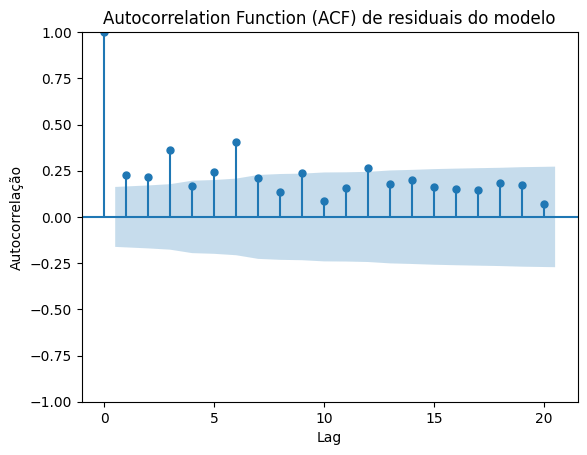

Accurácia da previsão
RMSE: 16923.85008126091
MAE: 15077.483545590754
MAPE: 0.716790535659928



In [27]:
btc = databtc()
prevMLP(btc, 1)

[*********************100%***********************]  1 of 1 completed
144
37
[[160.06416321 161.56651306 152.21069336 153.93919373 158.92948914
  155.26771545 157.70718384 158.12037659 160.22416687 156.54754639
  158.70545959 158.03793335 156.4262085  156.78434753 158.2855835
  160.32949829 159.21882629 162.16339111 162.41989136 162.09362793
  162.11958313 162.51071167 163.61671448 159.5622406  162.78260803
  153.15402222 153.66047668 151.26608276 157.5        157.36422729
  157.60606384 159.79107666 156.88517761 153.84681702 153.32824707
  154.71839905 156.45655823]]
previstos
[[159.33673 163.44531 143.13365 146.22942 165.7634  155.55383 149.92084
  161.59055 145.04185 152.81485 157.81027 157.41768 167.85408 168.53003
  161.44826 164.20123 159.30775 162.76994 161.90518 162.05019 157.00304
  139.48962 175.68933 159.44269 156.56425 153.65732 154.28653 148.84627
  149.4381  147.681   146.29787 165.09683 159.93193 158.71335 157.58475
  156.88837 159.7124 ]]
Data:2023-03-25 00:00:00 Previst

<Figure size 1000x400 with 0 Axes>

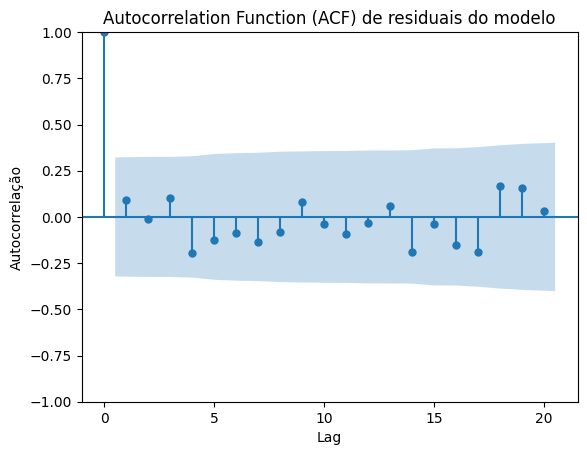

Accurácia da previsão
RMSE: 7.2287326805565995
MAE: 5.181449683936867
MAPE: 0.03272137587695892



In [28]:
xmr = dataxmr()
prevMLP(xmr, 0)

[*********************100%***********************]  1 of 1 completed
144
37
[[90.71494885 91.45710014 86.81939105 87.67912666 90.15378624 88.33900662
  89.54866217 89.75329322 90.7940355  88.97396085 90.04292491 89.71246967
  88.91379328 89.09136432 89.83509009 90.84609276 90.29693304 91.75168781
  91.87823659 91.71726414 91.73007161 91.9230377  92.46834388 90.46678714
  92.05714174 87.28875867 87.54058711 86.34898088 89.4460277  89.37875862
  89.49857181 90.5799422  89.14134731 87.63321361 87.37540292 88.06625525
  88.92884335]]
previstos
[[160.35115 166.30592 161.19469 160.73862 152.30254 149.35667 152.98918
  161.63568 172.43709 144.91278 159.65645 164.03178 155.4895  146.77786
  150.64001 165.79678 169.36624 147.51358 161.24641 173.08134 156.53456
  156.18121 164.59453 159.34663 163.58238 150.19545 140.13336 164.64993
  166.37277 160.06618 154.61757 149.51707 172.64955 163.65709 135.90594
  148.43549 161.94202]]
Data:2023-03-25 00:00:00 Previsto: 160.3511505126953 Atual: 160.064163

<Figure size 1000x400 with 0 Axes>

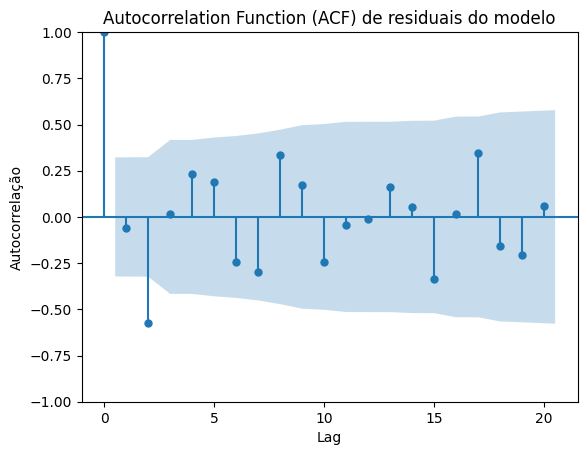

Accurácia da previsão
RMSE: 8.343140425176399
MAE: 6.93967293404245
MAPE: 0.04415607577633696



In [29]:
xmr = dataxmr()
prevMLP(xmr, 1)

[*********************100%***********************]  1 of 1 completed
144
37
[[1743.76477051 1775.67675781 1715.46081543 1772.78564453 1793.00183105
  1792.73718262 1822.02209473 1813.8605957  1795.70812988 1810.29711914
  1871.00512695 1909.11401367 1872.92260742 1865.6361084  1849.49816895
  1859.38781738 1911.20751953 1892.18969727 1920.68212891 2012.63464355
  2101.63549805 2092.46679688 2120.00585938 2076.24291992 2104.53735352
  1936.40344238 1943.09765625 1849.99987793 1874.2286377  1862.06201172
  1842.75744629 1866.75366211 1866.56420898 1908.78637695 1892.51281738
  1908.91699219 1876.92431641]]
previstos
[[1783.0266 1831.5665 1801.0621 1852.3759 1726.2471 1751.9764 1760.7794
  1705.2825 1767.9697 1762.3573 1831.1725 1915.0951 1832.5154 1850.7717
  1682.6593 1939.294  1971.5543 1780.5181 1912.4531 2195.6865 2072.6472
  2169.6685 2201.9373 2108.734  2096.8599 1916.2241 1805.9756 1893.3615
  1789.0178 1679.27   1607.2905 1959.2179 1865.3733 1891.861  1807.0103
  1922.1809 1874.2

<Figure size 1000x400 with 0 Axes>

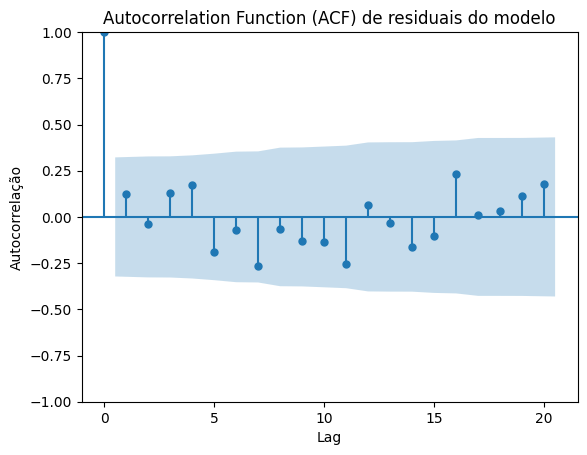

Accurácia da previsão
RMSE: 86.77464636361668
MAE: 66.72695510451858
MAPE: 0.03551817422170524



In [30]:
eth = dataeth()
prevMLP(eth, 0)

[*********************100%***********************]  1 of 1 completed
144
37
[[41.47681394 41.77921714 41.20570039 41.75196076 41.94197487 41.93949606
  42.21241879 42.13663373 41.96731011 42.10347774 42.6628718  43.00826475
  42.68035478 42.61385928 42.46600823 42.55670923 43.02711381 42.85540992
  43.11225868 43.92532646 44.69052328 44.61263907 44.84593662 44.47430115
  44.71512916 43.25296456 43.31266163 42.47061682 42.69225637 42.5811834
  42.40401358 42.62406841 42.62233797 43.00531368 42.85833619 43.00649019
  42.71680519]]
previstos
[[1444.6342 1455.3134 1327.296  1456.9498 1537.3468 1658.162  1446.2496
  1633.5638 1652.6666 1660.368  1646.1085 1650.9603 1637.0205 1316.3898
  1646.4865 1655.8109 1683.7239 1727.6888 1537.6768 1621.8751 1616.3988
  1891.415  1574.212  1749.0804 1535.7043 1756.092  1557.1461 1477.1804
  1769.1589 1503.6445 1606.0935 1485.6616 1410.8848 1649.6724 1731.7286
  1625.0635 1617.5762]]
Data:2023-03-25 00:00:00 Previsto: 1444.6341552734375 Atual: 1743.76477

<Figure size 1000x400 with 0 Axes>

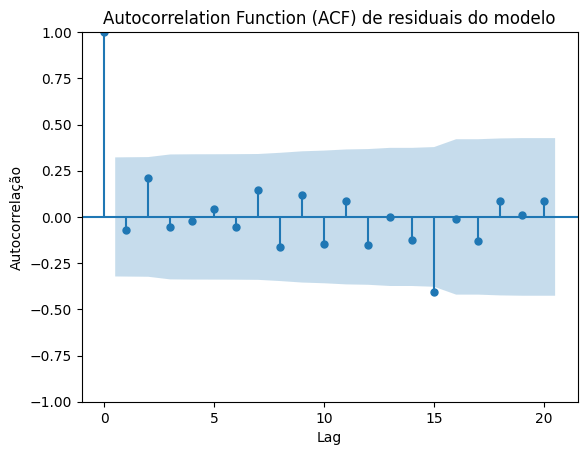

Accurácia da previsão
RMSE: 320.1395595862821
MAE: 296.49956780511
MAPE: 0.15608370935414728



In [31]:
eth = dataeth()
prevMLP(eth, 1)